# Predicting Likelihood of Purchasing a Vacation Home


## Import Required Packages

In [49]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Processing and Visualization Libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
import time
from random import randrange
import scorecardpy as sc
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Machine Learning Classifiers
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# Model Selection
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# Display settings
sns.set(color_codes=True)
pd.options.display.max_columns = 20
plt.style.use("default")

import warnings
warnings.filterwarnings("ignore")

from IPython.core.display import display,HTML
display(HTML('<style>.prompt{width: 0px; min-width: 0px; visibility: collapse}</style>'))


Load the dataset from csv:

In [78]:
df = pd.read_csv("lv_data_liftcharted.csv")

## Data Exploration and Preprocessing

In [79]:
print("There are", df.shape[0], "individuals and", df.shape[1], "variables in the dataset.")

There are 110022 individuals and 122 variables in the dataset.


In [80]:
print(df.columns)

Index(['age', 'tax_amount', 'sale_price', 'household_age_range',
       'inf_presence_of_children', 'inf_length_of_residence',
       'merkle_marketing_rank', 'inf_cardholder_rank',
       'prob_opening_annuity_acct_in_12_mths', 'generic_risk_score',
       ...
       'consolidated_merkle_income_level_H',
       'consolidated_merkle_income_level_N',
       'consolidated_merkle_income_level_NA',
       'consolidated_merkle_income_level_Z', 'mega_marital_M',
       'mega_marital_NA', 'mega_marital_S', 'dsf_residence_N',
       'dsf_residence_NA', 'dsf_residence_Y'],
      dtype='object', length=122)


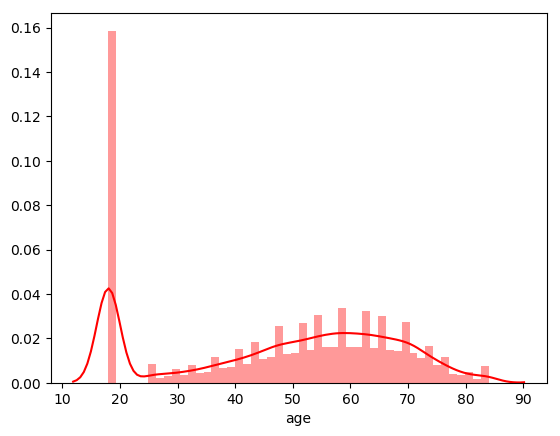

In [81]:
# Check if data distribution makes sense in each attributes, say "age" 
sns.distplot(df["age"], kde=True, color="red")
plt.show()

In [6]:
# Remove individuals with age <= 18
df = df[df["age"]>18]

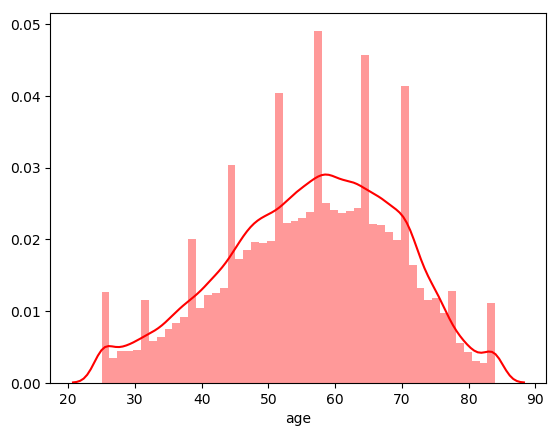

In [69]:
sns.distplot(df["age"], kde=True, color="red")
plt.show()

In [8]:
# drop variables with no more than 1 unique value, i.e. no predictive power
to_drop = list(df.nunique()[df.nunique()==1].index)
df = df.drop(to_drop, axis = 1)

### Correlation of Variables
Taking first 40 variables as example

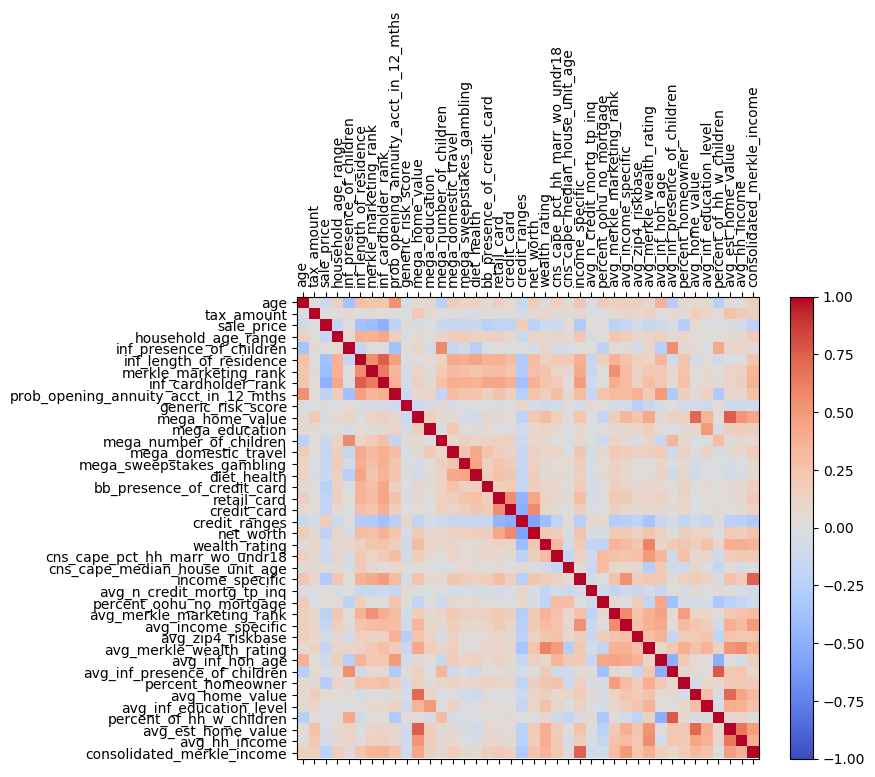

In [68]:
# correlation matrix
corr = df.iloc[:,0:40].corr()
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111)
cax = ax.matshow(corr,cmap='coolwarm', vmin=-1, vmax=1)
fig.colorbar(cax)
ticks = np.arange(0,len(df.iloc[:,0:40].columns),1)
plt.xticks(rotation=90)
ax.set_xticks(ticks)
ax.set_yticks(ticks)
ax.set_xticklabels(df.iloc[:,0:40].columns)
ax.set_yticklabels(df.iloc[:,0:40].columns)
ax.grid(False)
plt.show()

### Distribution Plots

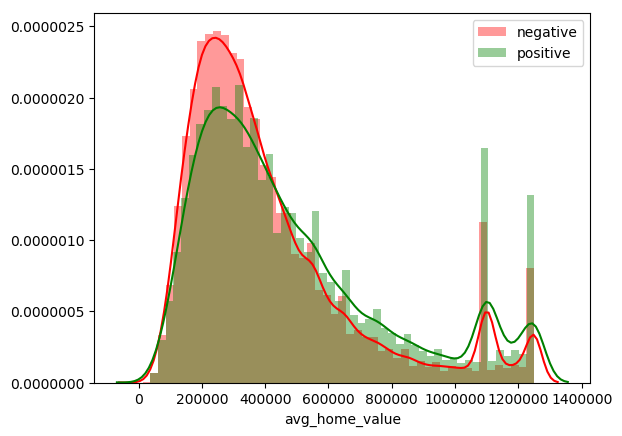

In [67]:
# Quick look at the correlation between each attribute and the responses
sns.distplot(df["avg_home_value"][df["y"]==0], kde=True, color="red", label="negative")
sns.distplot(df["avg_home_value"][df["y"]==1], kde=True, color="green", label="positive")
plt.legend()
plt.show()
# those sudden spikes may arise from imputation

### Weight of Evidence Binning and Information Value

In [11]:
# Weight of evidence (WOE) binning
bins = sc.woebin(df, y="y")

Binning on 86033 rows and 116 columns in 00:00:15


In [12]:
print(bins["avg_home_value"])

         variable                  bin  count  count_distr   good    bad  \
0  avg_home_value      [-inf,480000.0)  59114     0.687108  37833  21281   
1  avg_home_value  [480000.0,720000.0)  14242     0.165541   7796   6446   
2  avg_home_value       [720000.0,inf)  12677     0.147350   6170   6507   

    badprob       woe    bin_iv  total_iv    breaks  is_special_values  
0  0.359999 -0.161216  0.017532  0.059158  480000.0              False  
1  0.452605  0.224001  0.008464  0.059158  720000.0              False  
2  0.513292  0.467331  0.033162  0.059158       inf              False  


{'avg_home_value': <Figure size 640x480 with 2 Axes>}

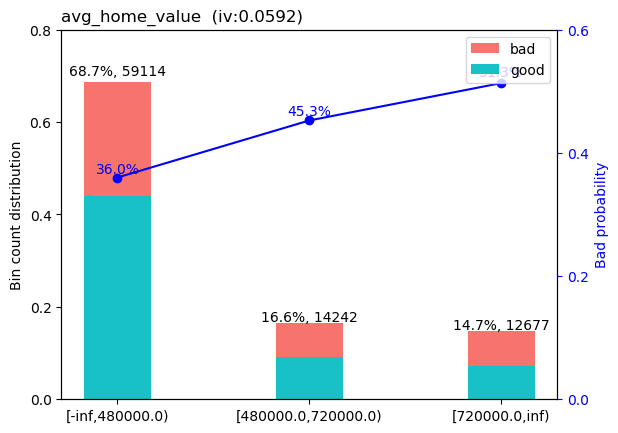

In [66]:
sc.woebin_plot(bins["avg_home_value"] )

In [14]:
# List the top 20 attributes in terms of information value (IV) 
iv_df = pd.DataFrame()
for i in list(iter(bins)):
    iv_df = iv_df.append(bins[i][["variable","total_iv"]].head(1))
iv_df = iv_df.sort_values(by=["total_iv"],ascending=False)

print(iv_df.head(20).to_string(index=False))

variable  total_iv
             hawaii_distance  0.921449
                 mb_distance  0.903870
                 lv_distance  0.860573
                 ny_distance  0.853531
            orlando_distance  0.827314
                 cnt_tour_lv  0.575010
reserv_oth_recordcount_index  0.574229
              cnt_package_lv  0.518313
        pkg_records_index_mb  0.473416
       pkg_records_index_orl  0.397181
                 cnt_sale_lv  0.299279
               ts_revenue_lv  0.298784
                cnt_tour_orl  0.294628
             cnt_package_orl  0.261380
        pkg_records_index_lv  0.257026
      htc_other_revenue_rank  0.183720
    pkg_records_index_hawaii  0.156393
                 cnt_tour_mb  0.118117
         day_since_ts_avg_mb  0.109431
silver_stayrecordcount_index  0.104937


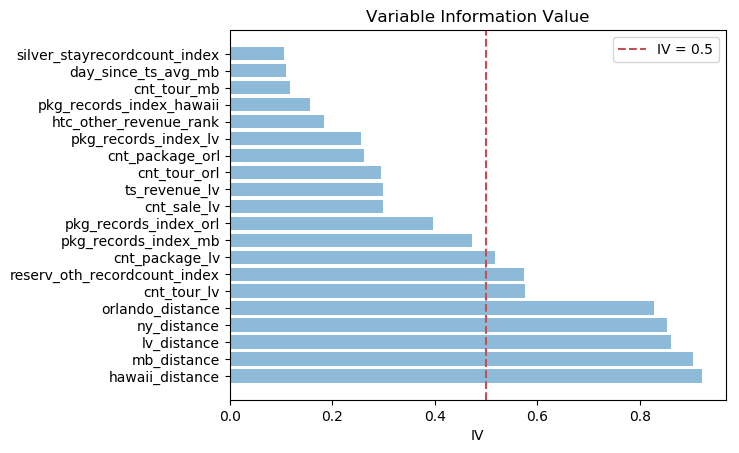

In [65]:
objects = (list(iv_df["variable"].head(20)))
y_pos = np.arange(len(objects))
performance = list(iv_df["total_iv"].head(20))
 
plt.subplot().barh(y_pos, performance, align='center', alpha=0.5)
plt.axvline(0.5, color='r', linestyle='--', label="IV = 0.5")
plt.yticks(y_pos, objects)
plt.xlabel('IV')
plt.title('Variable Information Value')
plt.legend()
 
plt.show()

In [16]:
# Exclude attributes with skepticalinformation values (IV > 0.5)
df = df.drop(list(iv_df["variable"][iv_df["total_iv"]>0.5]), axis=1)

In [17]:
# Check if the response ratio is still good for machine learning training 
# Also make sure all category data are transformed into numeric data. If not, one-ot encoding or dummy method can be applied. 
print(df["y"].value_counts(normalize = False, dropna = False))
print(df.dtypes.value_counts())

0    51799
1    34234
Name: y, dtype: int64
int64      68
float64    40
dtype: int64


### Data Imputation

In [18]:
# Check counts of NA in each attributes
df.isna().sum()

age                                     0
tax_amount                              0
sale_price                              0
household_age_range                     0
inf_presence_of_children                0
inf_length_of_residence                 0
merkle_marketing_rank                   0
inf_cardholder_rank                     0
prob_opening_annuity_acct_in_12_mths    0
generic_risk_score                      0
mega_home_value                         0
mega_education                          0
mega_number_of_children                 0
mega_domestic_travel                    0
mega_sweepstakes_gambling               0
diet_health                             0
bb_presence_of_credit_card              0
retail_card                             0
credit_card                             0
credit_ranges                           0
net_worth                               0
wealth_rating                           0
cns_cape_pct_hh_marr_wo_undr18          0
cns_cape_median_house_unit_age    

In [19]:
# Replace all NA with mean values of the corresponding variables
df_new = df.fillna(df.mean())

### Split Data

In [20]:
# Randomly split dataframe into train and test with a certain ratio
msk = np.random.rand(len(df_new)) < 0.67
train = df_new[msk]
test = df_new[~msk]

In [21]:
# Assign independent variables as x and the target variable as y
x_train = train.drop("y", axis=1).values
y_train = train["y"].values
x_test = test.drop("y", axis=1).values
y_test = test["y"].values

### Feature Scaling

Normalize the range of independent variables to ensure the variable weights are not influenced by the scale difference as well as to improve the convergence speed of algorithms

In [22]:
min_max_scaler = MinMaxScaler()
x_train = min_max_scaler.fit_transform(x_train)
x_test = min_max_scaler.fit_transform(x_test)

In [23]:
# Check again to ensure variables are correctly normalized
x_train

array([[0.37288136, 0.01184815, 0.00894772, ..., 0.        , 0.        ,
        1.        ],
       [0.66101695, 0.02397521, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.59322034, 0.02143327, 0.00799584, ..., 0.        , 0.        ,
        1.        ],
       ...,
       [0.74576271, 0.01566797, 0.01275526, ..., 0.        , 0.        ,
        1.        ],
       [0.3220339 , 0.04242022, 0.06261026, ..., 0.        , 0.        ,
        1.        ],
       [0.16949153, 0.01092697, 0.00437867, ..., 0.        , 0.        ,
        1.        ]])

## Machine Learning Methods
Evaluate the performance of various available machine learning algorithms and packages in terms of ROC, accuracy and speed

### Grid Search
Grid search builds a model for every combination of hyperparameters specified and evaluates each model. It is used for choosing a set of optimal hyperparameters for a learning algorithm.

In [50]:
# Lets take random forest as an example
rf = RandomForestClassifier()
n_estimators = range(10, 80, 10)
max_depth = [10, 14, 18]
print(max_depth)
param_grid = dict(max_depth=max_depth, n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=7)
grid_search = GridSearchCV(rf, param_grid, scoring="roc_auc", n_jobs=-1, cv=kfold, verbose=1)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

[10, 14, 18]
Fitting 10 folds for each of 21 candidates, totalling 210 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   25.7s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done 210 out of 210 | elapsed:  5.1min finished


Best: 0.803752 using {'max_depth': 14, 'n_estimators': 70}
0.791418 (0.005019) with: {'max_depth': 10, 'n_estimators': 10}
0.797234 (0.005736) with: {'max_depth': 10, 'n_estimators': 20}
0.798839 (0.005360) with: {'max_depth': 10, 'n_estimators': 30}
0.799895 (0.005072) with: {'max_depth': 10, 'n_estimators': 40}
0.800418 (0.004915) with: {'max_depth': 10, 'n_estimators': 50}
0.800971 (0.005089) with: {'max_depth': 10, 'n_estimators': 60}
0.800951 (0.005364) with: {'max_depth': 10, 'n_estimators': 70}
0.784996 (0.004319) with: {'max_depth': 14, 'n_estimators': 10}
0.793818 (0.005389) with: {'max_depth': 14, 'n_estimators': 20}
0.798667 (0.005896) with: {'max_depth': 14, 'n_estimators': 30}
0.799987 (0.005939) with: {'max_depth': 14, 'n_estimators': 40}
0.801995 (0.005515) with: {'max_depth': 14, 'n_estimators': 50}
0.802313 (0.004802) with: {'max_depth': 14, 'n_estimators': 60}
0.803752 (0.005091) with: {'max_depth': 14, 'n_estimators': 70}
0.774563 (0.006108) with: {'max_depth': 18, '

[0.79141824 0.79723369 0.79883853 0.79989491 0.80041771 0.80097092
 0.80095102 0.78499568 0.7938175  0.79866735 0.79998677 0.80199489
 0.80231267 0.8037524  0.77456263 0.78924505 0.79381024 0.79700251
 0.79882164 0.79983425 0.80192097]


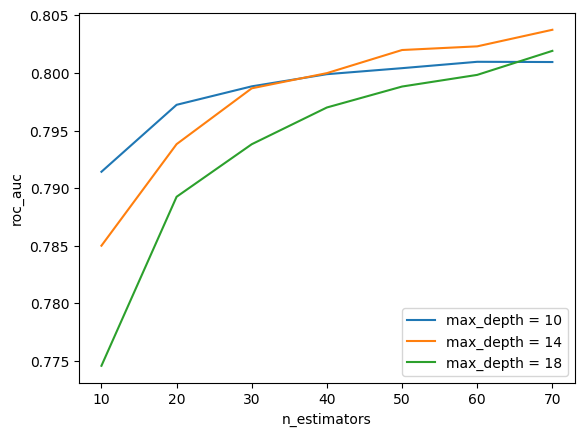

In [51]:
# Plot grid search results
scores = np.array(means).reshape(len(max_depth), len(n_estimators))
print(means)
for i, value in enumerate(max_depth):
    plt.plot(n_estimators, scores[i], label='max_depth = ' + str(value))
plt.legend()
plt.xlabel('n_estimators')
plt.ylabel('roc_auc')
plt.savefig('n_estimators_vs_max_depth.png')

Grid search results indicate a better performance when max_depth = 14 is used. Although we could achieve slightly better performance using even more estimators, estimator = 50 shows a good balance between computational cost and predictive power.

### Machine Learning Setups and Evaluations

In [52]:
# Set general hyperparameters for all ML packages using the grid search result
max_depth = 10
n_estimator = 50
random_state = 110

#### Sklearn Logistic Regression (LR)

In [53]:
start = time. time()
lr = LogisticRegression(max_iter=500, solver='lbfgs',
                          random_state=random_state)
lr.fit(x_train, y_train)
acc_lr = accuracy_score(y_test, lr.predict(x_test))
y_pred_lr = lr.predict_proba(x_test)[:, 1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_pred_lr)
end = time. time()
time_lr = end - start
print (time_lr, "s")

3.9456958770751953 s


#### Sklearn Logistic Regression (LR_SGD)
training with stochastic gradient descent (SGD) learning

In [54]:
start = time. time()
lr_sgd = SGDClassifier(max_iter=500, loss="log",
                          random_state=random_state)
lr_sgd.fit(x_train, y_train)
acc_lr_sgd = accuracy_score(y_test, lr_sgd.predict(x_test))
y_pred_lr_sgd = lr_sgd.predict_proba(x_test)[:, 1]
fpr_lr_sgd, tpr_lr_sgd, _ = roc_curve(y_test, y_pred_lr_sgd)
auc_lr_sgd = roc_auc_score(y_test, y_pred_lr_sgd)
end = time. time()
time_lr_sgd = end - start
print ("The entire evaluation takes", time_lr_sgd, "s")

The entire evaluation takes 10.650347471237183 s


#### Sklearn Random Forest (RF)

In [55]:
start = time. time()
rf = RandomForestClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
rf.fit(x_train, y_train)
acc_rf = accuracy_score(y_test, rf.predict(x_test))
y_pred_rf = rf.predict_proba(x_test)[:, 1]
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_pred_rf)
auc_rf = roc_auc_score(y_test, y_pred_rf)
end = time. time()
time_rf = end - start
print ("The entire evaluation takes", time_rf, "s")

The entire evaluation takes 7.164766311645508 s


#### Sklearn Gradient Boosting (GB)

In [56]:
start = time. time()
grd = GradientBoostingClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
grd.fit(x_train, y_train)
acc_grd = accuracy_score(y_test, grd.predict(x_test))
y_pred_grd = grd.predict_proba(x_test)[:, 1]
fpr_grd, tpr_grd, _ = roc_curve(y_test, y_pred_grd)
auc_grd = roc_auc_score(y_test, y_pred_grd)
end = time. time()
time_grd = end - start
print ("The entire evaluation takes", time_grd, "s")

The entire evaluation takes 243.47346663475037 s


#### XGBoost (XGB)

In [57]:
start = time. time()
xgb = XGBClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1)
xgb.fit(x_train,y_train)
acc_xgb = accuracy_score(y_test, xgb.predict(x_test))
y_pred_xgb = xgb.predict_proba(x_test)[:, 1]
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_pred_xgb)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)
end = time. time()
time_xgb = end - start
print ("The entire evaluation takes", time_xgb, "s")

The entire evaluation takes 38.04212999343872 s


#### XGBoost (XGB_H)
using histogram based algorithm

In [58]:
start = time. time()
xgb_h = XGBClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1, tree_method = "hist")
xgb_h.fit(x_train,y_train)
acc_xgb_h = accuracy_score(y_test, xgb_h.predict(x_test))
y_pred_xgb_h = xgb_h.predict_proba(x_test)[:, 1]
fpr_xgb_h, tpr_xgb_h, _ = roc_curve(y_test, y_pred_xgb_h)
auc_xgb_h = roc_auc_score(y_test, y_pred_xgb_h)
end = time. time()
time_xgb_h = end - start
print ("The entire evaluation takes", time_xgb_h, "s")

The entire evaluation takes 21.05069589614868 s


#### LightGBM (LGBM)

In [59]:
start = time. time()
lgb = LGBMClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state)
lgb.fit(x_train,y_train)
acc_lgb = accuracy_score(y_test, lgb.predict(x_test))
y_pred_lgb = lgb.predict_proba(x_test)[:, 1]
fpr_lgb, tpr_lgb, _ = roc_curve(y_test, y_pred_lgb, drop_intermediate=False)
auc_lgb = roc_auc_score(y_test, y_pred_lgb)
end = time. time()
time_lgb = end - start
print ("The entire evaluation takes", time_lgb, "s")

The entire evaluation takes 3.027604341506958 s


#### CatBoost (CB)

In [60]:
start = time. time()
CB = CatBoostClassifier(max_depth=max_depth, n_estimators=n_estimator,
                          random_state=random_state, eta = 0.1, verbose=0)
CB.fit(x_train,y_train)
acc_CB = accuracy_score(y_test, CB.predict(x_test))
y_pred_CB = CB.predict_proba(x_test)[:, 1]
fpr_CB, tpr_CB, _ = roc_curve(y_test, y_pred_CB)
auc_CB = roc_auc_score(y_test, y_pred_CB)
end = time. time()
time_CB = end - start
print ("The entire evaluation takes", time_CB, "s")

The entire evaluation takes 11.771530389785767 s


Plot ROC curves

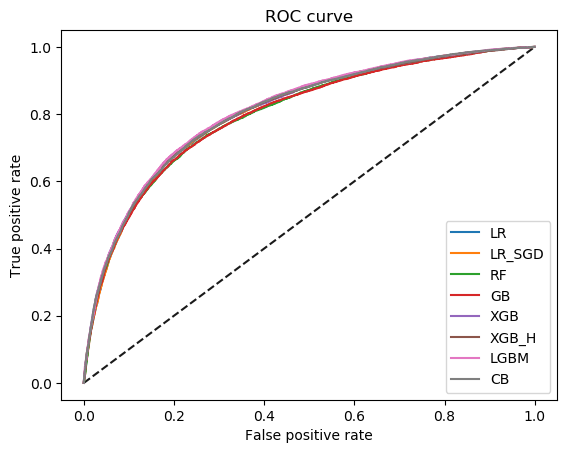

In [61]:
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lr, tpr_lr, label='LR')
plt.plot(fpr_lr_sgd, tpr_lr_sgd, label='LR_SGD')
plt.plot(fpr_rf, tpr_rf, label='RF')
plt.plot(fpr_grd, tpr_grd, label='GB')
plt.plot(fpr_xgb, tpr_xgb, label='XGB')
plt.plot(fpr_xgb_h, tpr_xgb_h, label='XGB_H')
plt.plot(fpr_lgb, tpr_lgb, label='LGBM')
plt.plot(fpr_CB, tpr_CB, label='CB')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()

Compare AUC values

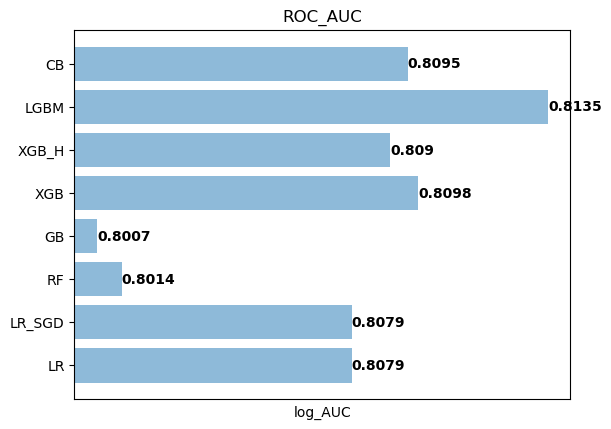

In [62]:
objects = ["LR", "LR_SGD", "RF", "GB", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_auc = [auc_lr, auc_lr_sgd, auc_rf, auc_grd, auc_xgb, auc_xgb_h, auc_lgb, auc_CB]
y_auc = [round(elem, 4) for elem in y_auc]
 
plt.barh(y_pos, y_auc, align='center', alpha=0.5, log=True)
plt.yticks(y_pos, objects)
plt.xlabel('log_AUC')
plt.title('ROC_AUC')

for i, v in enumerate(y_auc):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

Compare accuracy values

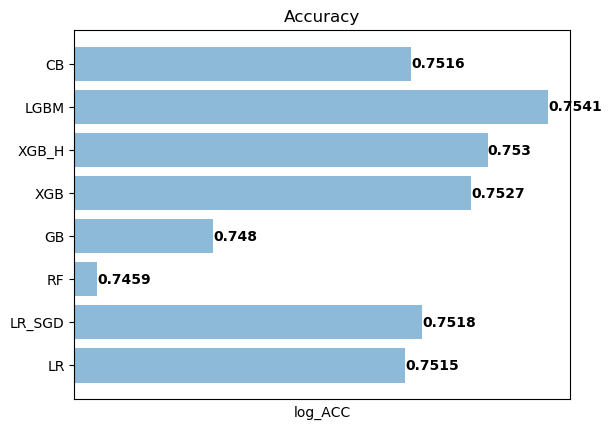

In [63]:
objects = ["LR", "LR_SGD", "RF", "GB", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_acc = [acc_lr, acc_lr_sgd, acc_rf, acc_grd, acc_xgb, acc_xgb_h, acc_lgb, acc_CB]
y_acc = [round(elem, 4) for elem in y_acc]
 
plt.barh(y_pos, y_acc, align='center', alpha=0.5, log=True)
plt.yticks(y_pos, objects)
plt.xlabel('log_ACC')
plt.title('Accuracy')

for i, v in enumerate(y_acc):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

Compare speed

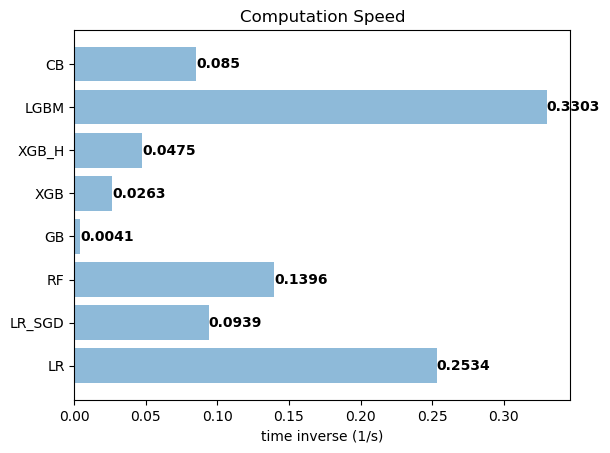

In [64]:
objects = ["LR", "LR_SGD", "RF", "GB", "XGB", "XGB_H", "LGBM", "CB"]
y_pos = np.arange(len(objects))
y_time = [1/time_lr, 1/time_lr_sgd, 1/time_rf, 1/time_grd, 1/time_xgb, 1/time_xgb_h, 1/time_lgb, 1/time_CB]
y_time = [round(elem, 4) for elem in y_time]
 
plt.barh(y_pos, y_time, align='center', alpha=0.5, log=False)
plt.yticks(y_pos, objects)
plt.xlabel('time inverse (1/s)')
plt.title('Computation Speed')

for i, v in enumerate(y_time):
    plt.text(v, i, str(v), va='center', color='black', fontweight='bold')
    
plt.show()

### Lift Chart

In [39]:
lift = dict()

In [40]:
def lift_table(data, auc, method):
    df_pred = pd.DataFrame(y_test, columns=["y_test"]).join(pd.DataFrame(data, columns=["prediction"]))
    df_pred = df_pred.sort_values("prediction", ascending=False).reset_index(drop=True)

    cnt_p = sum(df_pred["y_test"])
    cnt = len(df_pred)
    cnt_n = cnt - cnt_p
    p_pct = cnt_p/cnt
    decile = round(cnt/10)

    df_lift = pd.DataFrame(index=range(0,10), columns=["decile","counts of response","total counts","counts of non-response","response rate","cum sale rate","cum % of response","cum % of non-response","K-S","Inc. lift","cum lift"])

    for i in range(10):
        if i < (10-1):
            cnt_p_d = df_lift["counts of response"][i] = sum(df_pred["y_test"][i*decile:(i+1)*decile])
            df_lift["total counts"][i] = decile
            cnt_n_d = df_lift["counts of non-response"][i] = decile - cnt_p_d
            df_lift["response rate"][i] = cnt_p_d/decile
            cum_p = df_lift["cum sale rate"][i] = sum(df_pred["y_test"][0:(i+1)*decile])/((i+1)*decile)
            cum_p_pct = df_lift["cum % of response"][i] = cum_p*(i+1)*decile/cnt_p
            cum_n_pct = df_lift["cum % of non-response"][i] = (1-cum_p)*(i+1)*decile/cnt_n


        else:
            cnt_p_d = df_lift["counts of response"][i] = sum(df_pred["y_test"][i*decile:cnt])
            df_lift["total counts"][i] = cnt - i*decile
            cnt_n_d = df_lift["counts of non-response"][i] = cnt - i*decile - cnt_p_d
            df_lift["response rate"][i] = cnt_p_d/(cnt-i*decile)
            cum_p = df_lift["cum sale rate"][i] = sum(df_pred["y_test"][0:cnt])/(cnt)
            cum_p_pct = df_lift["cum % of response"][i] = cum_p*cnt/cnt_p
            cum_n_pct = df_lift["cum % of non-response"][i] = (1-cum_p)*cnt/cnt_n

    df_lift["decile"] = range(1, 11, 1)
    df_lift["K-S"] = df_lift["cum % of response"] - df_lift["cum % of non-response"]
    df_lift["Inc. lift"] = df_lift["response rate"]/p_pct
    df_lift["cum lift"] = df_lift["cum sale rate"]/df_lift["cum sale rate"][9]

    lift[method] = df_lift
    
    print(("%s" % method).upper())
    display(df_lift)
    print("response = ", cnt_p)
    print("non-response = ", cnt_n)
    print("total = ", cnt)
    print("response rate = ", p_pct)
    print("AUC = ", auc)
    print("-"*80)
    print()

In [70]:
lift_table(y_pred_grd, auc_grd, grd) # to show all detailed parameters, just remove ""
lift_table(y_pred_rf, auc_rf, rf)
lift_table(y_pred_lgb, auc_lgb, lgb)
lift_table(y_pred_lr, auc_lr, lr)

GRADIENTBOOSTINGCLASSIFIER(CRITERION='FRIEDMAN_MSE', INIT=NONE,
              LEARNING_RATE=0.1, LOSS='DEVIANCE', MAX_DEPTH=10,
              MAX_FEATURES=NONE, MAX_LEAF_NODES=NONE,
              MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
              MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
              MIN_WEIGHT_FRACTION_LEAF=0.0, N_ESTIMATORS=50,
              N_ITER_NO_CHANGE=NONE, PRESORT='AUTO', RANDOM_STATE=110,
              SUBSAMPLE=1.0, TOL=0.0001, VALIDATION_FRACTION=0.1,
              VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2427,2837,410,0.855481,0.855481,0.214608,0.0240371,0.190571,2.14578,2.14578
1,2,2116,2837,721,0.745858,0.80067,0.401715,0.0663071,0.335408,1.87081,2.00829
2,3,1762,2837,1075,0.621079,0.740806,0.557521,0.129331,0.428189,1.55783,1.85814
3,4,1388,2837,1449,0.489249,0.677917,0.680255,0.214282,0.465973,1.22717,1.7004
4,5,1027,2837,1810,0.362002,0.614734,0.771067,0.320396,0.450671,0.907998,1.54192
5,6,819,2837,2018,0.288685,0.560392,0.843487,0.438706,0.404782,0.7241,1.40561
6,7,633,2837,2204,0.223123,0.512211,0.899461,0.567919,0.331541,0.559652,1.28476
7,8,517,2837,2320,0.182235,0.470964,0.945176,0.703934,0.241243,0.457094,1.1813
8,9,360,2837,2477,0.126895,0.432734,0.977009,0.849153,0.127857,0.318286,1.08541
9,10,260,2833,2573,0.0917755,0.398682,1,1,0,0.230198,1


response =  11309
non-response =  17057
total =  28366
response rate =  0.3986815201297328
AUC =  0.8006902086445207
--------------------------------------------------------------------------------

RANDOMFORESTCLASSIFIER(BOOTSTRAP=TRUE, CLASS_WEIGHT=NONE, CRITERION='GINI',
            MAX_DEPTH=10, MAX_FEATURES='AUTO', MAX_LEAF_NODES=NONE,
            MIN_IMPURITY_DECREASE=0.0, MIN_IMPURITY_SPLIT=NONE,
            MIN_SAMPLES_LEAF=1, MIN_SAMPLES_SPLIT=2,
            MIN_WEIGHT_FRACTION_LEAF=0.0, N_ESTIMATORS=50, N_JOBS=NONE,
            OOB_SCORE=FALSE, RANDOM_STATE=110, VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2449,2837,388,0.863236,0.863236,0.216553,0.0227473,0.193806,2.16523,2.16523
1,2,2131,2837,706,0.751146,0.807191,0.404987,0.0641379,0.340849,1.88407,2.02465
2,3,1721,2837,1116,0.606627,0.740336,0.557167,0.129566,0.427601,1.52158,1.85696
3,4,1370,2837,1467,0.482904,0.675978,0.678309,0.215571,0.462738,1.21125,1.69553
4,5,1053,2837,1784,0.371167,0.615016,0.771421,0.320162,0.451259,0.930986,1.54262
5,6,791,2837,2046,0.278816,0.558982,0.841365,0.440113,0.401253,0.699344,1.40208
6,7,673,2837,2164,0.237222,0.513017,0.900875,0.566981,0.333894,0.595017,1.28678
7,8,519,2837,2318,0.18294,0.471757,0.946768,0.702879,0.243889,0.458862,1.18329
8,9,370,2837,2467,0.130419,0.433831,0.979485,0.847511,0.131974,0.327127,1.08816
9,10,232,2833,2601,0.081892,0.398682,1,1,0,0.205407,1


response =  11309
non-response =  17057
total =  28366
response rate =  0.3986815201297328
AUC =  0.8014224209192262
--------------------------------------------------------------------------------

LGBMCLASSIFIER(BOOSTING_TYPE='GBDT', CLASS_WEIGHT=NONE, COLSAMPLE_BYTREE=1.0,
        IMPORTANCE_TYPE='SPLIT', LEARNING_RATE=0.1, MAX_DEPTH=10,
        MIN_CHILD_SAMPLES=20, MIN_CHILD_WEIGHT=0.001, MIN_SPLIT_GAIN=0.0,
        N_ESTIMATORS=50, N_JOBS=-1, NUM_LEAVES=31, OBJECTIVE=NONE,
        RANDOM_STATE=110, REG_ALPHA=0.0, REG_LAMBDA=0.0, SILENT=TRUE,
        SUBSAMPLE=1.0, SUBSAMPLE_FOR_BIN=200000, SUBSAMPLE_FREQ=0)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2440,2837,397,0.860063,0.860063,0.215757,0.0232749,0.192482,2.15727,2.15727
1,2,2154,2837,683,0.759253,0.809658,0.406225,0.0633171,0.342908,1.90441,2.03084
2,3,1798,2837,1039,0.633768,0.751028,0.565214,0.124231,0.440983,1.58966,1.88378
3,4,1432,2837,1405,0.504759,0.689461,0.691838,0.206601,0.485237,1.26607,1.72935
4,5,1059,2837,1778,0.373282,0.626225,0.785481,0.31084,0.47464,0.93629,1.57074
5,6,809,2837,2028,0.28516,0.569381,0.857017,0.429736,0.427281,0.715259,1.42816
6,7,602,2837,2235,0.212196,0.518354,0.910248,0.560767,0.349482,0.532244,1.30017
7,8,484,2837,2353,0.170603,0.474885,0.953046,0.698716,0.25433,0.427917,1.19114
8,9,335,2837,2502,0.118082,0.435241,0.982669,0.845401,0.137268,0.296182,1.0917
9,10,196,2833,2637,0.0691846,0.398682,1,1,0,0.173534,1


response =  11309
non-response =  17057
total =  28366
response rate =  0.3986815201297328
AUC =  0.8135431411481489
--------------------------------------------------------------------------------

LOGISTICREGRESSION(C=1.0, CLASS_WEIGHT=NONE, DUAL=FALSE, FIT_INTERCEPT=TRUE,
          INTERCEPT_SCALING=1, MAX_ITER=500, MULTI_CLASS='WARN',
          N_JOBS=NONE, PENALTY='L2', RANDOM_STATE=110, SOLVER='LBFGS',
          TOL=0.0001, VERBOSE=0, WARM_START=FALSE)


,decile,counts of response,total counts,counts of non-response,response rate,cum sale rate,cum % of response,cum % of non-response,K-S,Inc. lift,cum lift
0,1,2412,2837,425,0.850194,0.850194,0.213281,0.0249165,0.188365,2.13251,2.13251
1,2,2132,2837,705,0.751498,0.800846,0.401804,0.0662485,0.335555,1.88496,2.00874
2,3,1796,2837,1041,0.633063,0.744918,0.560615,0.127279,0.433336,1.58789,1.86845
3,4,1414,2837,1423,0.498414,0.683292,0.685649,0.210705,0.474943,1.25016,1.71388
4,5,1069,2837,1768,0.376806,0.621995,0.780175,0.314358,0.465817,0.945132,1.56013
5,6,816,2837,2021,0.287628,0.566267,0.85233,0.432843,0.419487,0.721447,1.42035
6,7,632,2837,2205,0.222771,0.517196,0.908215,0.562115,0.346099,0.558768,1.29727
7,8,473,2837,2364,0.166725,0.473387,0.95004,0.700709,0.24933,0.418192,1.18738
8,9,364,2837,2473,0.128305,0.435045,0.982227,0.845694,0.136533,0.321822,1.09121
9,10,201,2833,2632,0.0709495,0.398682,1,1,0,0.17796,1


response =  11309
non-response =  17057
total =  28366
response rate =  0.3986815201297328
AUC =  0.8079022263484412
--------------------------------------------------------------------------------



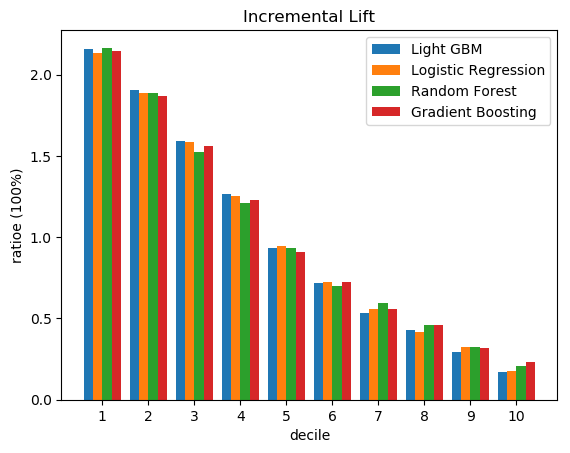

In [71]:
ax = plt.subplot(111)
wdt = 0.2
ax.bar(lift[lgb]["decile"]-3*wdt/2, lift[lgb]["Inc. lift"], width=wdt, label="Light GBM")
ax.bar(lift[lr]["decile"]-wdt/2, lift[lr]["Inc. lift"], width=wdt, label="Logistic Regression")
ax.bar(lift[rf]["decile"]+wdt/2, lift[rf]["Inc. lift"], width=wdt, label="Random Forest")
ax.bar(lift[grd]["decile"]+3*wdt/2, lift[grd]["Inc. lift"], width=wdt, label="Gradient Boosting")
plt.title("Incremental Lift")
plt.xlabel("decile")
plt.ylabel("ratioe (100%)")
plt.xticks(range(1,11))
plt.legend()
plt.show()    

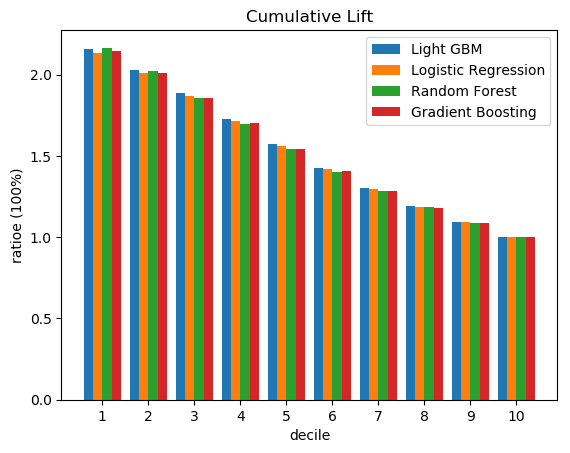

In [72]:
ax = plt.subplot(111)
wdt = 0.2
ax.bar(lift[lgb]["decile"]-3*wdt/2, lift[lgb]["cum lift"], width=wdt, label="Light GBM")
ax.bar(lift[lr]["decile"]-wdt/2, lift[lr]["cum lift"], width=wdt, label="Logistic Regression")
ax.bar(lift[rf]["decile"]+wdt/2, lift[rf]["cum lift"], width=wdt, label="Random Forest")
ax.bar(lift[grd]["decile"]+3*wdt/2, lift[grd]["cum lift"], width=wdt, label="Gradient Boosting")
plt.title("Cumulative Lift")
plt.xlabel("decile")
plt.ylabel("ratioe (100%)")
plt.xticks(range(1,11))
plt.legend()
plt.show()    

# Neural Network
This project can also be done using neural network which turn up with decent performance.

#### Define Model

In [73]:
# Define layer structure with 1 input, 1 output, and at least 1 hidden layer.
model = keras.Sequential([
    keras.layers.Dense(16, activation=tf.nn.relu),
    keras.layers.Dense(2, activation=tf.nn.sigmoid)
])

#### Compile Model

In [74]:
# Choose appropriate algorithms for the optimizer and loss function
model.compile(optimizer="adam", 
              loss='binary_crossentropy',
              metrics=['binary_accuracy'])

#### Fit Model

In [75]:
history = model.fit(x_train, y_train, batch_size=32, epochs=20, validation_split=0.5)

Train on 28833 samples, validate on 28834 samples
Epoch 1/20
28833/28833 [==============================] - 1s 40us/sample - loss: 0.5663 - binary_accuracy: 0.7113 - val_loss: 0.5366 - val_binary_accuracy: 0.7409
Epoch 2/20
28833/28833 [==============================] - 1s 35us/sample - loss: 0.5267 - binary_accuracy: 0.7476 - val_loss: 0.5298 - val_binary_accuracy: 0.7449
Epoch 3/20
28833/28833 [==============================] - 1s 36us/sample - loss: 0.5226 - binary_accuracy: 0.7490 - val_loss: 0.5294 - val_binary_accuracy: 0.7434
Epoch 4/20
28833/28833 [==============================] - 1s 36us/sample - loss: 0.5208 - binary_accuracy: 0.7506 - val_loss: 0.5271 - val_binary_accuracy: 0.7451
Epoch 5/20
28833/28833 [==============================] - 1s 35us/sample - loss: 0.5188 - binary_accuracy: 0.7517 - val_loss: 0.5257 - val_binary_accuracy: 0.7458
Epoch 6/20
28833/28833 [==============================] - 1s 35us/sample - loss: 0.5177 - binary_accuracy: 0.7528 - val_loss: 0.5296 - 

#### Model evaluation

In [76]:
test_loss, test_acc = model.evaluate(x_test, y_test)

print('Test accuracy:', test_acc)

28366/28366 [==============================] - 0s 11us/sample - loss: 0.5209 - binary_accuracy: 0.7524
Test accuracy: 0.7523796


#### Make predictions

ROC value = 0.8094780156766377


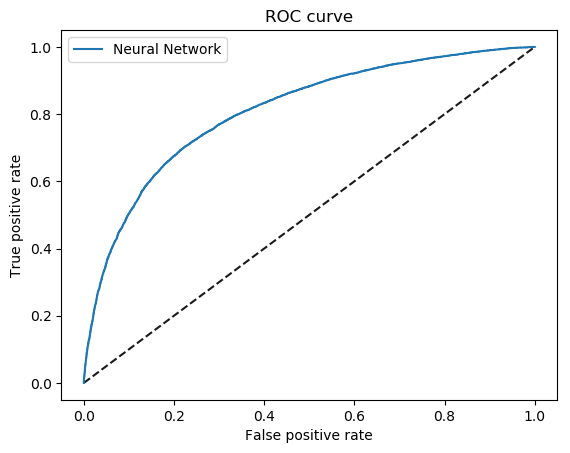

In [77]:
predictions = model.predict(x_test)
y_pred_nn = model.predict_proba(x_test)[:,1]
fpr_nn, tpr_nn, _ = roc_curve(y_test, y_pred_nn)
print("ROC value =", roc_auc_score(y_test, y_pred_nn))

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_nn, tpr_nn, label='Neural Network')
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()